# PENSE EM HIDROLOGIA ESTATÍSTICA
### Universidade Federal de Alagoas - UFAL
### Centro de Tecnologia - CTEC
### Programa de Pós-Graduação em Recursos Hídricos e Saneamento - PPGRHS
### Disciplina de Estatística

#### WALLISSON MOREIRA DE CARVALHO
##### BASEADO NOS LIVROS: THINK STATS 2ª ed. e Hidrologia Estatística

### CAPÍTULO 0 - INFORMAÇÕES INICIAIS

##### IMPORTANDO AS BIBLIOTECAS

In [1]:
import converte_dados #CÓDIGO PROPRIO DESENVOLVIDO PARA CONVERSÃO DOS DADOS HIDROWEB e ONS
import pandas as pd
import calendar
import thinkplot
import thinkstats2
from thinkstats2 import Pmf
from penseplot import gantt_plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
from math import ceil, log
import scipy
from scipy.stats import genextreme as gev
from scipy.stats import expon,norm,pareto
from lmoments3 import distr
import random
import statsmodels.formula.api as smf
import statsmodels.tsa.stattools as smtsa
import warnings
warnings.filterwarnings("ignore")

##### IMPORTANDO OS DADOS

In [2]:
dir_dados = 'Dados_Vazoes' #DIRETÓRIO DOS DADOS
vazao_observada = converte_dados.hidroweb(dir_dados)
vazao_observada = vazao_observada.rename(columns={vazao_observada.columns[0]:'Observada'})
#CÓDIGO DOS DADOS REFERENTES À UHE TRÊS MARIAS É 156
vazao_natural = converte_dados.ons(dir_dados+'/ONS_Diarias_1931_2016.xls','156')
vazao_natural = vazao_natural.rename(columns={vazao_natural.columns[0]:'Natural'})
vazoes=pd.concat([vazao_observada,vazao_natural],axis=1)

### CAPÍTULO 1 - ANÁLISE EXPLORATÓRIA DE DADOS

#### DataFrame

In [3]:
#O atributo head retorna os primeiros n dados
vazoes.head(n=5)

,Observada,Natural
1931-01-01,NaN,1293.0
1931-01-02,NaN,1265.0
1931-01-03,NaN,1139.0
1931-01-04,NaN,1056.0
1931-01-05,NaN,989.0


In [4]:
#   O atibuto info retorna informações referentes ao dataframe, como o período total de dados, e a quantidade de dados 
# não nulos de cada coluna.
vazoes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31412 entries, 1931-01-01 to 2016-12-31
Data columns (total 2 columns):
Observada    16893 non-null float64
Natural      31412 non-null float64
dtypes: float64(2)
memory usage: 736.2 KB


#### Gráfico de Gantt

In [5]:
gantt_plot(vazoes)

#### Seleção

In [6]:
inicio = pd.to_datetime(['01/08/1965'])
fim = pd.to_datetime(['31/01/1999'])
vazoes_sf=vazoes.loc[inicio[0]:fim[0]]
vazoes_sf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12442 entries, 1965-01-08 to 1999-01-31
Data columns (total 2 columns):
Observada    12342 non-null float64
Natural      12442 non-null float64
dtypes: float64(2)
memory usage: 291.6 KB


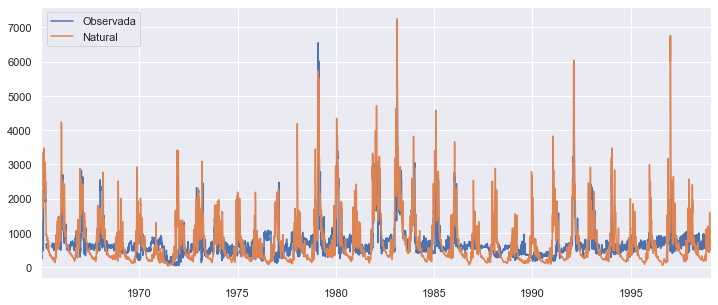

In [7]:
_=vazoes_sf.plot(figsize=(12,5))

### CAPÍTULO 2 - DISTRIBUIÇÕES

##### Aplicações

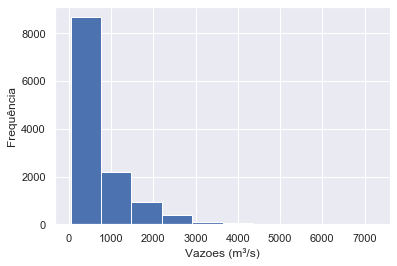

In [8]:
# Plotando histograma Vazões Naturais
_ = plt.hist(vazoes_sf['Natural'])

# Label axes
_ = plt.xlabel('Vazoes (m³/s)')
_ = plt.ylabel('Frequência')

# Show histogram
plt.show()

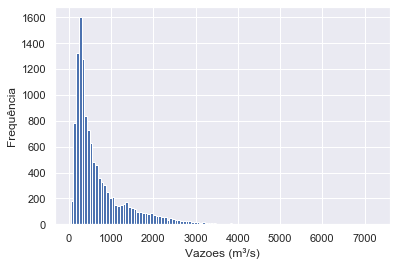

In [9]:
# Compute number of data points: n_data
n_data=len(vazoes_sf['Natural'])
# Number of bins is the square root of number of data points: n_bins
n_bins=np.sqrt(n_data)
# Convert number of bins to integer: n_bins
n_bins=int(n_bins)
# Plot the histogram
_ = plt.hist(vazoes_sf['Natural'],bins=n_bins)
# Label axes
_ = plt.xlabel('Vazoes (m³/s)')
_ = plt.ylabel('Frequência')
# Show histogram
plt.show()

#### Bee Swarm Plot (Swarm Plot)

In [10]:
medias=vazoes.groupby(by=[vazoes.index.year]).mean()

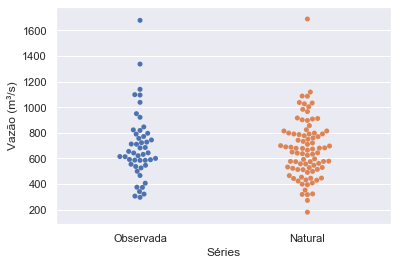

In [11]:
# Create bee swarm plot with Seaborn's default settings
_ = sns.swarmplot(data=medias)

# Label the axes
_ = plt.xlabel('Séries')
_ = plt.ylabel('Vazão (m³/s)')
# Show the plot
plt.show()

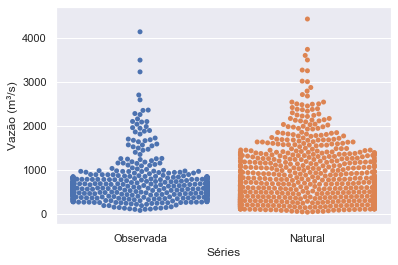

In [12]:
medias=vazoes.groupby(by=[vazoes.index.year,vazoes.index.month]).mean()
# Create bee swarm plot with Seaborn's default settings
_ = sns.swarmplot(data=medias)

# Label the axes
_ = plt.xlabel('Séries')
_ = plt.ylabel('Vazão (m³/s)')
# Show the plot
plt.show()

#### Estatísticas Resumo

#### Box plots

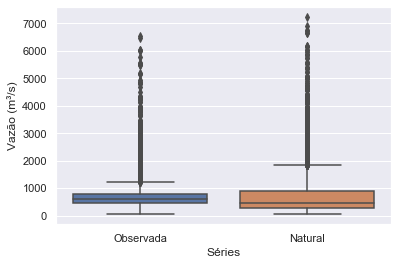

In [13]:
# Create box plot with Seaborn's default settings
_ = sns.boxplot(data=vazoes_sf)

# Label the axes
_ = plt.xlabel('Séries')
_ = plt.ylabel('Vazão (m³/s)')


# Show the plot
plt.show()

### CAPÍTULO 3 - Funções Massa de Probabilidade

#### Aplicação

In [14]:
Qrisco = vazoes_sf['Natural'].quantile(0.99)
vazoes_pmf = pd.DataFrame()
vazoes_pmf['Natural'] = vazoes_sf['Natural'].apply(lambda x: 1 if x>=Qrisco else 0)
vazoes_pmf['Observada'] = vazoes_sf['Observada'].apply(lambda x: 1 if x>=Qrisco else 0)
vazoes_pmf=vazoes_pmf.groupby(pd.Grouper(freq='1A')).sum()
vazoes_pmf.head()

,Natural,Observada
1965-12-31,3,0
1966-12-31,5,0
1967-12-31,0,0
1968-12-31,0,0
1969-12-31,0,0


In [15]:
pmf_natural = Pmf(vazoes_pmf['Natural'],label='Natural')
pmf_observada = Pmf(vazoes_pmf['Observada'],label='Observada')

In [16]:
print('A probabilidade para vazões naturais é de {}%, no caso das observadas é de {}%'
      .format(round(pmf_natural[0]*100,2),round(pmf_observada[0]*100,2)))

A probabilidade para vazões naturais é de 57.14%, no caso das observadas é de 88.57%


#### Plotando FMPs

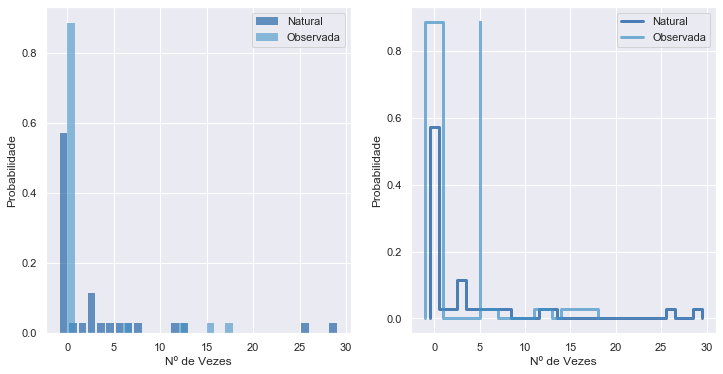

<Figure size 576x432 with 0 Axes>

In [17]:
#Plotando Gráfico de Barras
thinkplot.PrePlot(2, cols=2)
thinkplot.Hist(pmf_natural, align='right',width=0.8)
thinkplot.Hist(pmf_observada, align='left',width=0.8)
thinkplot.Config(xlabel='Nº de Vezes', ylabel='Probabilidade')

#Plotando usando 'Step Functions'
thinkplot.PrePlot(2)
thinkplot.SubPlot(2)
thinkplot.Pmfs([pmf_natural, pmf_observada])
thinkplot.Show(xlabel='Nº de Vezes', ylabel='Probabilidade')

### CAPÍTULO 4 - Função de Distribuição Acumulada

In [18]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1,n+1) / n

    return x, y

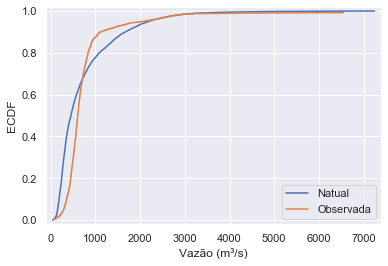

In [19]:
x_1, y_1 = ecdf(vazoes_sf['Natural'])
x_2, y_2 = ecdf(vazoes_sf['Observada'])
_ = plt.plot(x_1, y_1, marker=' ', linestyle = '-')
_ = plt.plot(x_2, y_2, marker=' ', linestyle = '-')
plt.legend(('Natual', 'Observada'), loc='lower right')
_ = plt.xlabel('Vazão (m³/s)')
_ = plt.ylabel('ECDF')

# Display the plot
plt.margins(0.02)
plt.show()

#### Curva de Permanência

In [20]:
def curva_permanencia(dados,logscale=True):
    plt.figure(num=None,facecolor='w', edgecolor='k')
    plt.grid(True,which="both",ls="-")
    ymax=0
    for name in dados.columns:
        serie=dados[name].dropna()
        n=len(serie)
        y = np.sort(serie)
        y = y[::-1]
        if ymax < y.max():
            ymax=y.max()
        x = (np.arange(1,n+1) / n)*100
        _ = plt.plot(x,y,linestyle='-') 
    plt.legend(list(dados.columns), loc='best')
    plt.margins(0.02) 
    if logscale==True:
        ticks = 10**np.arange(1,ceil(log(ymax,10)) + 1,1)
        ticks[-1:]+=1
        plt.yticks(list(ticks))
        plt.yscale('log')
        plt.tick_params(axis='y', which='minor')
        
    _ = plt.xlabel('Probabilidade de excedência ou igualdade (%)')
    _ =  plt.ylabel('Vazão m³/s')
    plt.xticks(np.arange(0,101,step=10))
    plt.show()

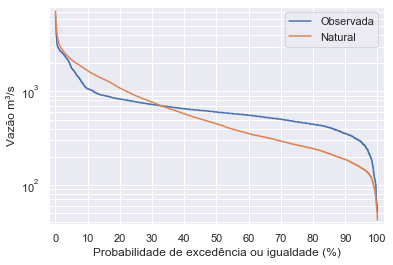

In [21]:
curva_permanencia(vazoes_sf)

#### Comparando Rank de Percentis

In [22]:
rk_nat = scipy.stats.percentileofscore(vazoes_sf['Natural'],1000)
rk_obs = scipy.stats.percentileofscore(vazoes_sf['Observada'],1000)
print('Rank de Percentil de 1000 m³/s para vazões naturais foi de  {}% e para observadas foi de {}%'
      .format(round(rk_nat,2),round(rk_obs,2)))

Rank de Percentil de 1000 m³/s para vazões naturais foi de  77.89% e para observadas foi de 87.49%


### CAPÍTULO 05 - Modelagem de Distribuições e Capítulo 06 - Função de Densidade de Probabilidades

#### Distribuição Exponencial

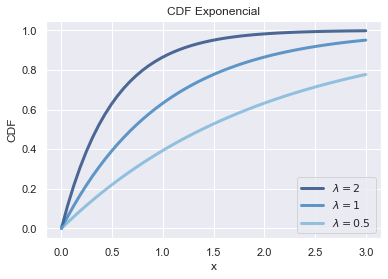

In [23]:
thinkplot.PrePlot(3)
for lam in [2.0, 1, 0.5]:
    xs, ps = thinkstats2.RenderExpoCdf(lam, 0, 3.0, 50)
    label = r'$\lambda=%g$' % lam
    thinkplot.Plot(xs, ps, label=label)
    
thinkplot.Config(title='CDF Exponencial', xlabel='x', ylabel='CDF')

In [24]:
def expon_distribution(dados):
    mu,sigma=expon.fit(dados)
    lin = np.linspace(0, 14, num=100)
    expon_cdf = expon.cdf(lin, mu, sigma)
    _=plt.plot(lin, expon_cdf, color='blue')
    _ = plt.xlabel('Tempo (anos)')
    _ =  plt.ylabel('CDF')

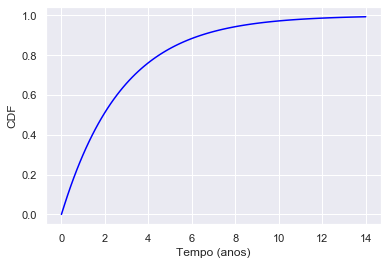

In [25]:
tempo=pd.Series(vazoes[vazoes['Natural']>6200]['Natural'].index)
tempo.sort_values()
diffs=[]
for i in range(len(tempo)-1):
    diffs.append(((tempo[i+1]-tempo[i]).days/365))
expon_distribution(diffs)

#### Distribuição Normal

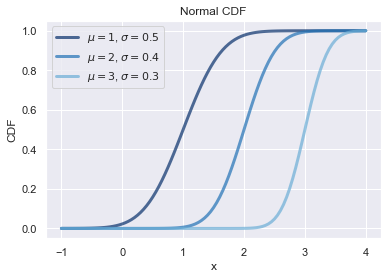

In [26]:
thinkplot.PrePlot(3)

mus = [1.0, 2.0, 3.0]
sigmas = [0.5, 0.4, 0.3]
for mu, sigma in zip(mus, sigmas):
    xs, ps = thinkstats2.RenderNormalCdf(mu=mu, sigma=sigma, 
                                               low=-1.0, high=4.0)
    label = r'$\mu=%g$, $\sigma=%g$' % (mu, sigma)
    thinkplot.Plot(xs, ps, label=label)

thinkplot.Config(title='Normal CDF', xlabel='x', ylabel='CDF',
                 loc='upper left')

In [27]:
dir_dados = 'Dados_Chuvas' #DIRETÓRIO DOS DADOS
chuva = converte_dados.hidroweb(dir_dados)
chuva = chuva.rename(columns={chuva.columns[0]:'Chuva'})

In [28]:
def ano_hidrologico_chuva(chuva):
    media_mensal=chuva['Chuva'].groupby(chuva['Chuva'].index.month).mean()
    mes_menor_media=calendar.month_abbr[media_mensal.idxmin()+1].upper()
    frequencia='AS-'+mes_menor_media
    chuva_ah=chuva['Chuva'].groupby(pd.Grouper(freq=frequencia)).sum().sort_index()
    chuva_ah=chuva_ah[1:-1]
    chuva_ah.index=chuva_ah.index.year
    return chuva_ah

In [29]:
chuva_ah = ano_hidrologico_chuva(chuva)

In [30]:
def normal_cdf(dados, label):   
    mean = dados.mean()
    std_dev = dados.std()
    lin = norm.rvs(size=10000, loc=mean, scale=std_dev) 
    x = np.sort(lin)
    normal = norm.cdf(x, mean, std_dev)
    _=plt.plot(x, normal, color='orange', label=label)

def normal_pdf(acumulado_anual):
    ax = acumulado_anual.plot(kind='density')
    mean = acumulado_anual.mean()
    std_dev = acumulado_anual.std()
    lin = np.linspace(0, 2500, num=50)
    normal = norm.pdf(lin, mean, std_dev)
    plt.plot(lin, normal)
    ax.legend(('Empírico','Analítico')) 

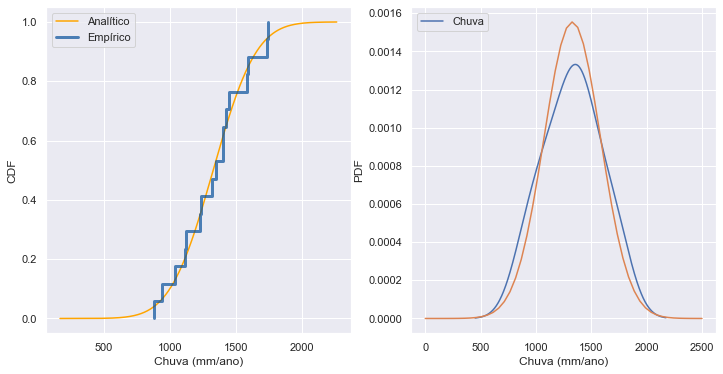

In [31]:
thinkplot.PrePlot(1, cols=2)
normal_cdf(chuva_ah, label='Analítico')
cdf = thinkstats2.Cdf(chuva_ah, label='Empírico')
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Chuva (mm/ano)', ylabel='CDF', legend=True)

thinkplot.SubPlot(2)
normal_pdf(chuva_ah) 
thinkplot.Config(xlabel='Chuva (mm/ano)', ylabel='PDF', legend=True)

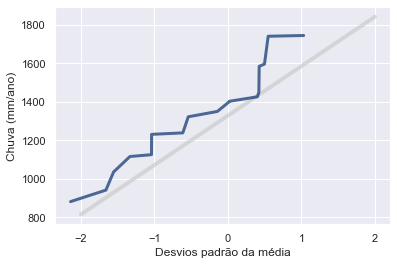

In [32]:
mean = chuva_ah.mean()
std = chuva_ah.std()
xs = [-2, 2]
fxs, fys = thinkstats2.FitLine(xs, mean, std)
thinkplot.Plot(fxs, fys, linewidth=4, color='0.8')

xs, ys = thinkstats2.NormalProbability(chuva_ah)

thinkplot.Plot(xs, ys)
thinkplot.Config(xlabel='Desvios padrão da média', ylabel='Chuva (mm/ano)', legend=True)

#### Distribuição LogNormal

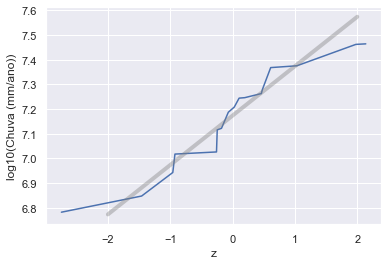

In [33]:
def log_normal_probability_plot(acumulado_anual):
    sorted_annual_mean=acumulado_anual.apply(np.log).sort_values()
    standard_normal=pd.Series(np.random.normal(size=len(acumulado_anual))).sort_values()
    _=plt.plot(standard_normal.values,sorted_annual_mean.values)
    mean = sorted_annual_mean.mean()
    std = sorted_annual_mean.std()
    xs = [-2, 2]
    fxs, fys = thinkstats2.FitLine(xs, mean, std)
    thinkplot.Plot(fxs, fys, linewidth=4, color='grey',alpha=0.4)

    
log_normal_probability_plot(chuva_ah)
thinkplot.Config(xlabel='z', ylabel='log10(Chuva (mm/ano))', legend=True)

#### Distribuição Pareto

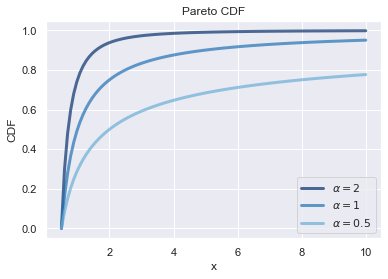

In [34]:
xmin = 0.5
thinkplot.PrePlot(3)
for alpha in [2.0, 1.0, 0.5]:
    xs, ps = thinkstats2.RenderParetoCdf(xmin, alpha, 0, 10.0, n=100) 
    thinkplot.Plot(xs, ps, label=r'$\alpha=%g$' % alpha)
    
thinkplot.Config(title='Pareto CDF', xlabel='x',
                 ylabel='CDF', loc='lower right')

In [35]:
def ano_hidrologico_vazoes(vazoes):
    media_mensal=vazoes['Natural'].groupby(vazoes['Natural'].index.month).mean()
    mes_menor_media=calendar.month_abbr[media_mensal.idxmin()+1].upper()
    frequencia='AS-'+mes_menor_media
    vazao_natural_ah=vazoes['Natural'].groupby(pd.Grouper(freq=frequencia)).max().sort_index()
    vazao_natural_ah=vazao_natural_ah[1:-1]
    vazao_obs_ah=vazoes['Observada'].groupby(pd.Grouper(freq=frequencia)).max().sort_index()
    vazao_obs_ah=vazao_obs_ah[1:-1]
    vazoes = pd.concat([vazao_obs_ah,vazao_natural_ah],axis=1)
    return vazoes
maximas_natural = ano_hidrologico_vazoes(vazoes)['Natural']

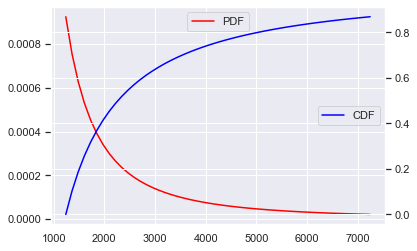

In [36]:
def pareto_distribution(maximos_anuais):
    #ax = maximos_anuais.plot(kind='density')
    
    a,b,c=pareto.fit(maximos_anuais)
    lin = np.linspace(maximos_anuais.min(), maximos_anuais.max(), num=50)
    pareto_pdf = pareto.pdf(lin, a,b,c)
    fig, ax1 = plt.subplots()
    pareto_cdf = pareto.cdf(lin, a,b,c)
    ax2 = ax1.twinx()
    ax1.plot(lin, pareto_pdf, color='red', label = 'PDF')
    ax1.legend(loc='upper center')
    ax2.plot(lin, pareto_cdf, color='blue',label='CDF')
    ax2.legend(loc='right')
    _ = plt.xlabel('Vazões Máximas Anuais Naturais (m³/s)')
pareto_distribution(maximas_natural)

### Capítulo 7 - Relações entre variáveis

In [37]:
chuva_vazao = pd.concat([chuva,vazao_natural],axis=1)
gantt_plot(chuva_vazao)

In [38]:
#BASEADO NO GRÁFICO DE GANTT
inicio = pd.to_datetime(['01/01/1975'])
fim = pd.to_datetime(['31/03/1993'])
chuva_vazao=chuva_vazao.loc[inicio[0]:fim[0]]
chuva_vazao.head()

,Chuva,Natural
1975-01-01,38.0,1673.0
1975-01-02,8.2,2040.0
1975-01-03,50.0,2193.0
1975-01-04,10.1,2177.0
1975-01-05,1.0,2175.0


#### Gráficos de Dispersão

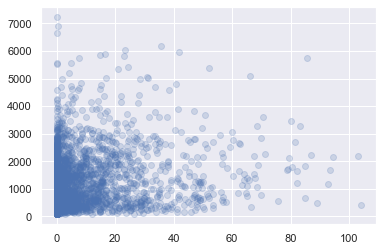

In [39]:
plt.scatter(chuva_vazao['Chuva'][:-6],chuva_vazao['Natural'][6:], alpha=0.2)
plt.show()

#### Caracterizando Relações

In [40]:
def plot_percentil(dados_chuva, dados_vazao):
    dados_month = pd.DataFrame([dados_chuva, dados_vazao])
    dados_month = dados_month.T
    
    dados_month = dados_month.dropna(subset=[dados_chuva.name, dados_vazao.name])
    bins = np.arange(0, 400, 40)
    indices = np.digitize(dados_month[dados_chuva.name], bins)
    groups = dados_month.groupby(indices)
    
    mean_chuva = [group[dados_chuva.name].mean() for i, group in groups]
    cdfs = [thinkstats2.Cdf(group[dados_vazao.name]) for i, group in groups]
    
    for percent in [75, 50, 25]:
        vazao_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(mean_chuva, vazao_percentiles, label=label)
        thinkplot.Config(xlabel='Chuva', ylabel='Vazão', legend=True)

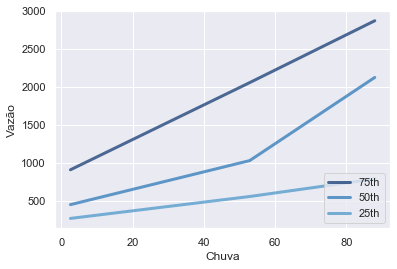

In [41]:
plot_percentil(chuva_vazao['Chuva'][:-6],chuva_vazao['Natural'][6:])

#### Correlação e Covariância

#### Coeficiente de Correlação de Pearson (p)

In [42]:
cov=chuva_vazao['Chuva'][:-6].cov(chuva_vazao['Natural'][6:])
Sx=chuva_vazao['Chuva'][:-6].std()
Sy=chuva_vazao['Natural'][6:].std()
p=cov/(Sx*Sy)

print('Covariância = {} \nDesvio padrão da série de chuvas = {}\n'
      'Desvio padrão da série de vazões = {}\nPearson Coef. = {}'
     .format(round(cov,2),round(Sx,2),round(Sy,2),round(p,2)))

Covariância = 2247.1 
Desvio padrão da série de chuvas = 10.28
Desvio padrão da série de vazões = 787.75
Pearson Coef. = 0.28


#### Correlação de ordem de classificação de Spearman

In [43]:
cr=chuva_vazao['Chuva'][:-6].corr(chuva_vazao['Natural'][6:],method='spearman').round(2)
print('Correlação de Spearman = {}'.format(round(cr,2)))

Correlação de Spearman = 0.36


#### Correlação e Causa

### Capítulo 8 - Estimação

<img src="estimadoress.png" width=60%>

#### Propriedades de um estimador

#### Principais Estimadores de Parâmetros

#### Melhor Estimador

#### Aplicação

In [44]:
def ano_hidrologico_vazoes(vazoes):
    media_mensal=vazoes['Natural'].groupby(vazoes['Natural'].index.month).mean()
    mes_menor_media=calendar.month_abbr[media_mensal.idxmin()+1].upper()
    frequencia='AS-'+mes_menor_media
    vazao_natural_ah=vazoes['Natural'].groupby(pd.Grouper(freq=frequencia)).max().sort_index()
    vazao_natural_ah=vazao_natural_ah[1:-1]
    vazao_obs_ah=vazoes['Observada'].groupby(pd.Grouper(freq=frequencia)).max().sort_index()
    vazao_obs_ah=vazao_obs_ah[1:-1]
    vazoes = pd.concat([vazao_obs_ah,vazao_natural_ah],axis=1)
    return vazoes

In [45]:
vazoes_maximas = ano_hidrologico_vazoes(vazoes_sf)
vazoes_maximas.head()

,Observada,Natural
1965-10-01,2702.1,4236.0
1966-10-01,2830.0,2884.0
1967-10-01,2553.3,2776.0
1968-10-01,917.6,2515.0
1969-10-01,1289.0,2925.0


#### Distribuição Normal

In [46]:
media_maxima=vazoes_maximas['Natural'].mean()
std_maxima=vazoes_maximas['Natural'].std(ddof=1)
print ('Média das máximas {}, desvio padrão das máximas {}'.format(round(media_maxima,2),round(std_maxima,2)))

Média das máximas 3421.12, desvio padrão das máximas 1429.42


In [47]:
def mse_normal(media_maxima,std_maxima,n=10):
    erro_media_maximas=[]
    erro_std_maximas=[]
    
    for i in range(1000):
        amostra_maximas=np.random.normal(media_maxima,std_maxima,n)
        erro_media_maximas.append((amostra_maximas.mean()-media_maxima)**2)
        erro_std_maximas.append((amostra_maximas.std()-std_maxima)**2)

    erro_media_maximas=sum(erro_media_maximas)/1000
    erro_std_maximas=sum(erro_std_maximas)/1000
    print('Erro quadrático médio, para amostras de tamanho n={}, em relação às máximas: Média {}, Desvio Padrão {},'
          .format(n,round(erro_media_maximas,2),round(erro_std_maximas,2)))

In [48]:
#Para n=10    
mse_normal(media_maxima,std_maxima)
#Para n=1000
mse_normal(media_maxima,std_maxima,1000)
#Para n=10000
mse_normal(media_maxima,std_maxima,n=10000)

Erro quadrático médio, para amostras de tamanho n=10, em relação às máximas: Média 213280.57, Desvio Padrão 111036.97,
Erro quadrático médio, para amostras de tamanho n=1000, em relação às máximas: Média 2154.53, Desvio Padrão 1078.47,
Erro quadrático médio, para amostras de tamanho n=10000, em relação às máximas: Média 207.34, Desvio Padrão 100.16,


#### Distribuição GEV

In [49]:
parameters = gev.fit(vazoes_maximas['Natural'])
print('Parâmetros encontrados: c={}, loc={}, scale={}'
      .format(round(parameters[0],2),round(parameters[1],2),round(parameters[2],2)))

Parâmetros encontrados: c=-5.48, loc=1311.82, scale=15.46


In [50]:
def mse_gev(parameters,n=10):
    error_c=[]
    error_loc=[]
    error_scale=[]
    cm, locm, scalem = parameters
    
    for i in range(1000):
        amostra_maximas=gev.rvs(cm, locm, scalem,n)
        parametros_amostra=gev.fit(amostra_maximas)
        ca, loca,scalea=parametros_amostra
        error_c.append((ca-cm)**2)
        error_loc.append((loca-locm)**2)
        error_scale.append((scalea-scalem)**2)

    error_c=sum(error_c)/1000
    error_loc=sum(error_loc)/1000
    error_scale=sum(error_scale)/1000
    print('Erro quadrático médio, para amostras de tamanho n={}, para c: {}, loc: {}, scale: {}'
          .format(n,round(error_c,2),round(error_loc,2),round(error_scale,2)))

In [51]:
#Para n=10    
mse_gev(parameters)
#Para n=50
mse_gev(parameters,50)
#Para n=100
mse_gev(parameters,100)

Erro quadrático médio, para amostras de tamanho n=10, para c: 3.19, loc: 11.17, scale: 395.1
Erro quadrático médio, para amostras de tamanho n=50, para c: 4.93, loc: 1.97, scale: 59.91
Erro quadrático médio, para amostras de tamanho n=100, para c: 7.78, loc: 21505.96, scale: 90.67


#### Achando a Variância

◘ $S^{2}$ é uma escolhar para estimar a variância($\sigma^{2}$);
    • Pode ser estimado por $S^{2} = \frac{1}{n} \sum (x_{i} - \bar{x})^{2}$
    
    • Para grandes amostras, S² é um estimador adequado
    
    • Para a mostra pequenas, possuí viés, tendendo a ser pequeno. Por causa disso, é chamado de um estimador enviezado.
    
◘  $S_{n-1}^{2} = \frac{1}{n-1} \sum (x_{i} - \bar{x})^{2}$ é um estimador não enviezado
 
    • Um estimador não é tendencioso quando o ser erro total, depois de muitas iterações, for 0;
    
    • Existe outra estatística não tendenciosa para estimar a variância


In [52]:
def estimar_var(mu = 0, sigma = 1, n=10, m=1000):

    estimatesb = []
    estimatesu = []
    for _ in range(m):
        xs = [random.gauss(mu, sigma) for _ in range(n)]
        biased = np.var(xs)
        unbiased = np.var(xs, ddof=1)
        estimatesb.append(biased)
        estimatesu.append(unbiased)
    def erro_medio(estimates, actual):
        errors = [estimate-actual for estimate in estimates]
        return np.mean(errors)

    print('Erro médio enviesado', round(erro_medio(estimatesb, sigma**2),2))
    print('Erro médio não-enviesado', round(erro_medio(estimatesu, sigma**2),2))

In [53]:
estimar_var(vazoes_maximas['Natural'].mean(),vazoes_maximas['Natural'].std(),100)

Erro médio enviesado -18245.76
Erro médio não-enviesado 2208.62


#### Bootstrap

In [54]:
maximas_natural = ano_hidrologico_vazoes(vazoes)
maximas_natural = maximas_natural['Natural']

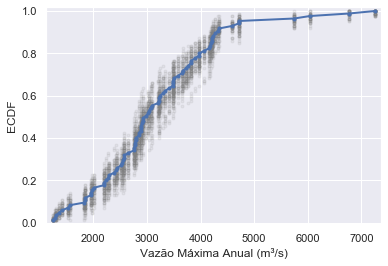

In [55]:
for _ in range(50):
    # Generate bootstrap sample: bs_sample
    bs_sample = np.random.choice(maximas_natural, size=len(maximas_natural))
    # Compute and plot ECDF from bootstrap sample
    x, y = ecdf(bs_sample)
    _ = plt.plot(x, y, marker='.', linestyle='none',
                 color='gray', alpha=0.1)
# Compute and plot ECDF from original data
x, y = ecdf(maximas_natural)
_ = plt.plot(x, y, marker='.',linewidth=2)
# Make margins and label axes
plt.margins(0.02)
_ = plt.xlabel('Vazão Máxima Anual (m³/s)')
_ = plt.ylabel('ECDF')
# Show the plot
plt.show()

In [56]:
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

123.35467890963773
124.15135316914458


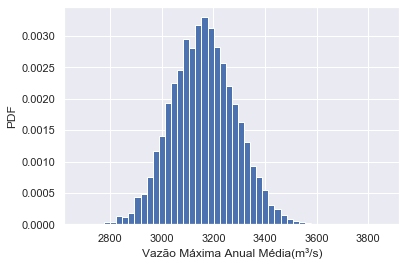

In [57]:
# Take 10,000 bootstrap replicates of the mean: bs_replicates
bs_replicates = draw_bs_reps(maximas_natural, np.mean, size=10000)

# Compute and print SEM
sem = np.std(maximas_natural) / np.sqrt(len(maximas_natural))
print(sem)

# Compute and print standard deviation of bootstrap replicates
bs_std = np.std(bs_replicates)
print(bs_std)

# Make a histogram of the results
_ = plt.hist(bs_replicates, bins=50, normed=True)
_ = plt.xlabel('Vazão Máxima Anual Média(m³/s)')
_ = plt.ylabel('PDF')

# Show the plot
plt.show()

In [58]:
# Take 10,000 bootstrap replicates of the mean: bs_replicates
bs_replicates = draw_bs_reps(maximas_natural, np.mean, size=10000)

# Compute and print SEM
sem = np.std(maximas_natural) / np.sqrt(len(maximas_natural))
print('Erro padrão da média {}'.format(round(sem,2)))

# Compute and print standard deviation of bootstrap replicates
bs_std = np.std(bs_replicates)
print('Desvio padrão das amostras bootstrap {}'.format(round(bs_std,2)))

Erro padrão da média 123.35
Desvio padrão das amostras bootstrap 122.33


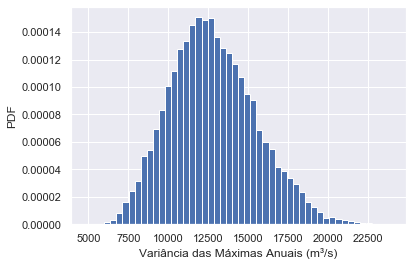

In [59]:
# Generate 10,000 bootstrap replicates of the variance: bs_replicates
bs_replicates = draw_bs_reps(maximas_natural,np.var,size=10000)

# Put the variance in units of square centimeters
bs_replicates=bs_replicates/100

# Make a histogram of the results
_ = plt.hist(bs_replicates, bins=50, normed=True)
_ = plt.xlabel('Variância das Máximas Anuais (m³/s)')
_ = plt.ylabel('PDF')

# Show the plot
plt.show()

In [60]:
# Compute the 95% confidence interval: conf_int
conf_int = np.percentile(bs_replicates, [2.5, 97.5])
# Print the confidence interval
print('Intervalo de confiança de 95% para a variância =', conf_int.round(2))

Intervalo de confiança de 95% para a variância = [ 8046.35 18460.57]


### Capítulo 9 - Teste de Hipóteses

#### O teste da Moeda

In [61]:
data = (140,110) #Número de vezes que apareceu cada uma (Caras,coroas)
iters= 10000 #Número de iterações que queremos assumir
def valorp(data,iters):
    H,T=data
    n=sum(data)
    atual=abs(H-T)
    def run_model(n):
        sample=[random.choice('HT') for i in range(n)]
        data=[sample.count('H'),sample.count('T')]
        diff=abs(data[0]-data[1])
        return diff
    test=[run_model(n) for _ in range(iters)]
    count=sum(1 for x in test if x>= atual)
    valorp=count/iters*100
    return valorp
valor_p=valorp(data,iters)
print('O valor-p para o teste foi de {}%'.format(round(valor_p,2)))

O valor-p para o teste foi de 6.91%


#### Permutação

In [62]:
def permutation_sample(data1, data2):
    """Gerar amostras de permutação para duas dois conjuntos de dados"""

    # Concatenate the data sets: data
    data = np.concatenate((data1,data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

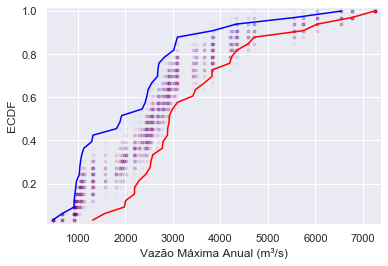

In [63]:
#Vizualiando amostras de permutação
niters=50
for _ in range(niters):
    # Gerando amostras de permutação
    perm_sample_1, perm_sample_2 = permutation_sample(
                                    vazoes_maximas['Natural'], vazoes_maximas['Observada'])

    # Compute ECDFs
    x_1, y_1 = ecdf(perm_sample_1)
    x_2, y_2 = ecdf(perm_sample_2)

    # Plot ECDFs da amostra de permutação
    _ = plt.plot(x_1, y_1, marker='.', linestyle='none',
                 color='red', alpha=0.02)
    _ = plt.plot(x_2, y_2, marker='.', linestyle='none',
                 color='blue', alpha=0.02)

# Criar e plotar ECDFs dos dados orignais
x_1, y_1 = ecdf(vazoes_maximas['Natural'])
x_2, y_2 = ecdf(vazoes_maximas['Observada'])
_ = plt.plot(x_1, y_1, marker=' ', linestyle='-', color='red')
_ = plt.plot(x_2, y_2, marker=' ', linestyle='-', color='blue')

# Label axes, set margin, and show plot
plt.margins(0.02)
_ = plt.xlabel('Vazão Máxima Anual (m³/s)')
_ = plt.ylabel('ECDF')
plt.show()

#### Teste Estatístico Usando Permutação

In [64]:
def draw_perm_reps(data_1, data_2, func, size=1):
    """Gerar replicações de múltiplas permutações."""

    # Inicializar um array de replicações: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Gerar amostras de permutação
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Calcular o teste estatístico
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

##### Diferença entre médias

In [65]:
def diff_of_means(data_1, data_2):
    """Diferença de média de dois arrays."""
    # A diferença de média de data_1, data_2: diff
    diff = abs(np.mean(data_1) - np.mean(data_2))
    return diff

# Calcular a diferença de média empirica
empirical_diff_means = diff_of_means(vazoes_maximas['Natural'], vazoes_maximas['Observada'])

# Fazer a permutação da diferença de médias 10000x : perm_replicates
perm_replicates = draw_perm_reps(vazoes_maximas['Natural'], vazoes_maximas['Observada'],
                                 diff_of_means, size=10000)

# Calcular o valor-p: p
p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)

# Gerar o resultado
print('p-value =', p)

p-value = 0.0003


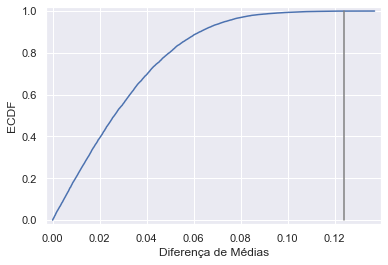

In [66]:
x_1, y_1 = ecdf(perm_replicates/len(perm_replicates))
_ = plt.plot(x_1, y_1, marker=' ', linestyle = '-')
_ = plt.xlabel('Diferença de Médias')
_ = plt.ylabel('ECDF')
vertical = empirical_diff_means/len(perm_replicates)
_ = plt.plot([vertical,vertical],[0,1], marker=' ', linestyle = '-', color='grey')

# Display the plot
plt.margins(0.02)
plt.show()

##### Outros testes

In [67]:
def diff_of_stds(data_1, data_2):
    """Diferença de média de dois arrays."""
    # A diferença de média de data_1, data_2: diff
    diff = abs(np.std(data_1) - np.std(data_2))
    return diff

# Calcular a diferença de média empirica
empirical_diff_stds = diff_of_stds(vazoes_maximas['Natural'], vazoes_maximas['Observada'])

# Fazer a permutação da diferença de médias 10000x : perm_replicates
perm_replicates = draw_perm_reps(vazoes_maximas['Natural'], vazoes_maximas['Observada'],
                                 diff_of_stds, size=10000)

# Calcular o valor-p: p
p = np.sum(perm_replicates >= empirical_diff_stds) / len(perm_replicates)

# Gerar o resultado
print('p-value =', p)

p-value = 0.9354


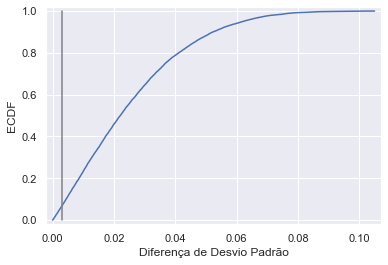

In [68]:
x_1, y_1 = ecdf(perm_replicates/len(perm_replicates))
_ = plt.plot(x_1, y_1, marker=' ', linestyle = '-')
_ = plt.xlabel('Diferença de Desvio Padrão')
_ = plt.ylabel('ECDF')
vertical = empirical_diff_stds/len(perm_replicates)
_ = plt.plot([vertical,vertical],[0,1], marker=' ', linestyle = '-', color='grey')

# Display the plot
plt.margins(0.02)
plt.show()

##### Testando Correlação

In [69]:
def correlacao(data_1, data_2):
    """Diferença de média de dois arrays."""
    # A diferença de média de data_1, data_2: diff
    corr = np.corrcoef(data_1,data_2)
    return corr[0][1]

# Calcular a diferença de média empirica
empirical_corr = correlacao(vazoes_maximas['Natural'], vazoes_maximas['Observada'])
print('Correlação Empírica =',empirical_corr.round(2))
# Fazer a permutação da diferença de médias 10000x : perm_replicates
perm_replicates = draw_perm_reps(vazoes_maximas['Natural'], vazoes_maximas['Observada'],
                                 correlacao, size=10000)

# Calcular o valor-p: p
p = np.sum(perm_replicates >= empirical_corr) / len(perm_replicates)

# Gerar o resultado
print('p-value =', p)

Correlação Empírica = 0.74
p-value = 0.0


### Erros

### Capítulo 10 - Mínimos Quadrados Linear

#### Aplicação

In [70]:
def ano_hidrologico_chuva_vazoes(chuva_vazao):
    #ANO HIDROLÓGICO VAZOES
    media_mensal=chuva_vazao['Natural'].groupby(chuva_vazao['Natural'].index.month).mean()
    mes_menor_media=calendar.month_abbr[media_mensal.idxmin()+1].upper()
    frequencia='AS-'+mes_menor_media
    vazao_natural_ah=chuva_vazao['Natural'].groupby(pd.Grouper(freq=frequencia)).mean().sort_index()
    vazao_natural_ah=vazao_natural_ah[1:-1].round(2)
    vazao_natural_ah.index = vazao_natural_ah.index.year
    
    #ANO HIDROLÓGICO CHUVAS
    media_mensal=chuva_vazao['Chuva'].groupby(chuva_vazao['Chuva'].index.month).mean()
    mes_menor_media=calendar.month_abbr[media_mensal.idxmin()+1].upper()
    frequencia='AS-'+mes_menor_media
    chuva_ah=chuva_vazao['Chuva'].groupby(pd.Grouper(freq=frequencia)).sum().sort_index()
    chuva_ah=chuva_ah[1:-1]
    chuva_ah.index=chuva_ah.index.year
    
    chuva_vazao_ah = pd.concat([chuva_ah,vazao_natural_ah],axis=1)
    return chuva_vazao_ah

In [71]:
chuva_vazao_ah = ano_hidrologico_chuva_vazoes(chuva_vazao)
chuva_vazao_ah.head()

,Chuva,Natural
1975,881.5,379.52
1976,1238.4,630.26
1977,1321.9,581.93
1978,1595.5,1109.96
1979,1448.3,937.24


O coeficiente de correlação de person é: r=0.67


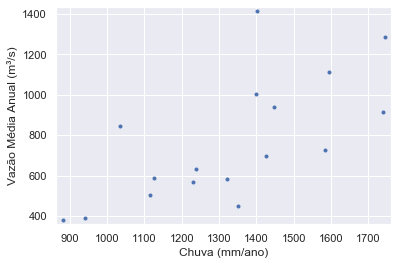

In [72]:
def pearson_r(x,y):
    """Compute Pearson correlation coefficient between two arrays."""
    corr_mat=np.corrcoef(x,y)
    return corr_mat[0,1]

# Compute Pearson correlation coefficient: r
r=pearson_r(chuva_vazao_ah['Chuva'], chuva_vazao_ah['Natural'])

# Print the result
print ("O coeficiente de correlação de person é: r={}".format(round(r,2)))

# Plot the illiteracy rate versus fertility
_ = plt.plot(chuva_vazao_ah['Chuva'], chuva_vazao_ah['Natural'], marker='.', linestyle='none')

# Set the margins and label axes
plt.margins(0.02)
_ = plt.xlabel('Chuva (mm/ano)')
_ = plt.ylabel('Vazão Média Anual (m³/s)')

# Show the plot
plt.show()

Parâmetro a =0.81, e b = -306.41


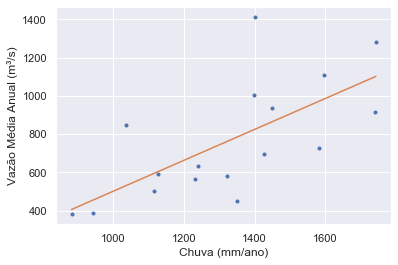

In [73]:
# Perform linear regression: a, b
a, b = np.polyfit(chuva_vazao_ah['Chuva'], chuva_vazao_ah['Natural'],1)

# Print the slope and intercept
print ('Parâmetro a ={}, e b = {}'.format(round(a,2),round(b,2)))

# Generate theoretical x and y data: x_theor, y_theor
x_theor = np.array([chuva_vazao_ah['Chuva'].min(), chuva_vazao_ah['Chuva'].max()])
y_theor = x_theor * a + b

# Plot the Anscombe data and theoretical line
_ = plt.plot(chuva_vazao_ah['Chuva'], chuva_vazao_ah['Natural'], marker='.', linestyle='none')
_ = plt.plot(x_theor, y_theor, marker=' ', linestyle='-')

# Label the axes
plt.xlabel('Chuva (mm/ano)')
plt.ylabel('Vazão Média Anual (m³/s)')

# Show the plot
plt.show()

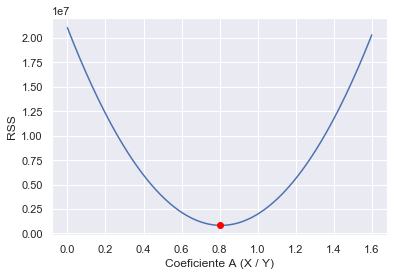

In [74]:
# Specify slopes to consider: a_vals
a_vals = np.linspace(0,1.6,200)

# Initialize sum of square of residuals: rss
rss = np.empty_like(a_vals)

# Compute sum of square of residuals for each value of a_vals
for i, a in enumerate(a_vals):
    rss[i] = np.sum((np.array(chuva_vazao_ah['Natural']) - np.array(chuva_vazao_ah['Chuva'])*a -b)**2)

# Compute the values of min
rss_minimo = rss.min()
loc_result = np.where(rss == rss.min())[0]
a_min = a_vals[loc_result]
# Plot the RSS
_ = plt.plot(a_vals, rss, '-')
_ = plt.plot(a_min,rss_minimo, '.',color='red',markersize=12)

#Plot the min

plt.xlabel('Coeficiente A (X / Y)')
plt.ylabel('RSS')

plt.show()

#### Resíduos

In [75]:
#Calcula o resíduo do ajuste para cada valor
res = thinkstats2.Residuals(chuva_vazao_ah['Chuva'], chuva_vazao_ah['Natural'], b, a)
res

array([ -724.46630006, -1044.76630006, -1226.69630006, -1136.42630006,
       -1073.62630006,  -904.58630006, -1200.66630006,  -523.56630006,
        -504.43630006,  -928.27630006, -1500.51630006,  -975.16630006,
       -1096.99630006,  -810.86630006, -1401.98630006, -1279.89630006,
       -1561.65630006])

In [76]:
def plot_residuos(dados_chuva, dados_vazao):
    dados_month = pd.DataFrame([dados_chuva, dados_vazao])
    dados_month = dados_month.T
    
    dados_month = dados_month.dropna(subset=[dados_chuva.name, dados_vazao.name])
    bins = np.arange(1200, 2000, 20)
    indices = np.digitize(dados_month[dados_chuva.name], bins)
    groups = dados_month.groupby(indices)
    
    mean_chuva = [group[dados_chuva.name].mean() for i, group in groups]
    cdfs = [thinkstats2.Cdf(group[dados_vazao.name]) for i, group in groups]
    
    for percent in [75, 50, 25]:
        vazao_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(mean_chuva, vazao_percentiles, label=label)
        thinkplot.Config(xlabel='Chuva', ylabel='Vazão', legend=True)

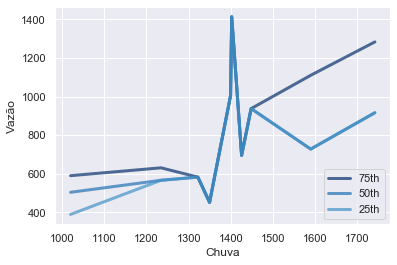

In [77]:
plot_residuos(chuva_vazao_ah['Chuva'], chuva_vazao_ah['Natural'])

#### Estimação e Intervalos de Confiança

In [78]:
def SamplingDistributions(x,y, iters=101):
    t = []
    for _ in range(iters):
        sample = thinkstats2.ResampleRows(chuva_vazao_ah)
        x = sample["Chuva"]
        y = sample["Natural"]
        estimates = thinkstats2.LeastSquares(x, y)
        t.append(estimates)
    inters, slopes = zip(*t)
    return inters, slopes

def Summarize(estimates, actual=None):
    mean = thinkstats2.Mean(estimates)
    stderr = thinkstats2.Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean: ', mean,  
          '\nSE: ',stderr, 
          '\nCI: ', ci)

def PlotConfidenceIntervals(xs, inters, slopes, percent=90, **options):
    fys_seq = []
    for inter, slope in zip(inters, slopes):
        fxs, fys = thinkstats2.FitLine(xs, inter, slope)
        fys_seq.append(fys)

    p = (100 - percent) / 2
    percents = p, 100 - p
    low, high = thinkstats2.PercentileRows(fys_seq, percents)
    thinkplot.FillBetween(fxs, low, high, **options)


In [79]:
inters, slopes = SamplingDistributions(chuva_vazao_ah['Chuva'], chuva_vazao_ah['Natural'], iters=1001)
print ('Resumo coeficiente b:')
print ('')
Summarize(inters)
print ('')
print ('Resumo coeficiente a:')
print ('')
Summarize(slopes)

Resumo coeficiente b:

mean:  -302.8405414205245 
SE:  236.5742655062073 
CI:  (-677.2387744976819, 97.95643253911373)

Resumo coeficiente a:

mean:  0.8046253830828245 
SE:  0.18446439124311848 
CI:  (0.5027650835017954, 1.1071190557784034)


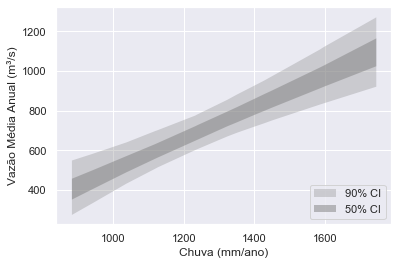

In [80]:
PlotConfidenceIntervals(chuva_vazao_ah['Chuva'], inters, slopes, percent=90, 
                        color='gray', alpha=0.3, label='90% CI')
PlotConfidenceIntervals(chuva_vazao_ah['Chuva'], inters, slopes, percent=50,
                        color='gray', alpha=0.5, label='50% CI')

thinkplot.Config(xlabel="Chuva (mm/ano)", ylabel='Vazão Média Anual (m³/s)')

#### Bondade de ajuste

In [81]:
r2 = thinkstats2.CoefDetermination(chuva_vazao_ah['Chuva'], res)
print('R² =', np.sqrt(r2).round(2))

R² = nan


#### Testando um modelo linear

 - Estatística do teste é $R^{2}$ e a hipótese nula é que não há relação entre as variáveis;
 - Um teste unilateral de $R_{2}$ é equivalente a um teste bilateral de $\rho$;
 - Outra abordagem é testar se a inclinação aparente se deve ao acaso.

In [82]:
class SlopeTest(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        chuva, vazao = data
        _, slope = thinkstats2.LeastSquares(chuva, vazao)
        return slope

    def MakeModel(self):
        _, vazao= self.data
        self.ybar = vazao.mean()
        self.res = vazao - self.ybar

    def RunModel(self):
        chuva, _ = self.data
        vazao = self.ybar + np.random.permutation(self.res)
        return chuva, vazao

In [83]:
ht = SlopeTest((chuva_vazao_ah['Chuva'], chuva_vazao_ah['Natural']))
pvalue = ht.PValue()

In [84]:
pvalue

0.001

In [85]:
reamostragem_cdf = thinkstats2.Cdf(slopes)

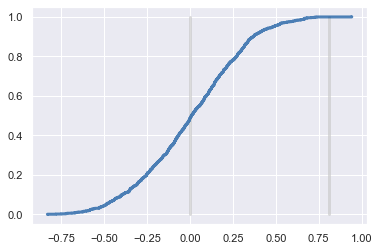

In [86]:
thinkplot.PrePlot(2)
thinkplot.Plot([0, 0], [0, 1], color='0.8')
ht.PlotCdf(label='Hipótese nula')

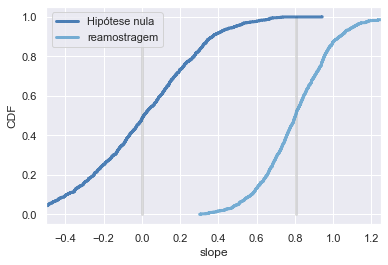

In [87]:
thinkplot.PrePlot(2)
thinkplot.Plot([0, 0], [0, 1], color='0.8')
ht.PlotCdf(label='Hipótese nula')

thinkplot.Cdf(reamostragem_cdf, label='reamostragem')

thinkplot.Config(xlabel='slope',
                 ylabel='CDF',
                 xlim=[-0.5, 1.25],
                 legend=True, loc='upper left')

### Capítulo 11 - Regressão

◘ O objetivo da análise de regressão é descrever a relação entre um conjunto de variáveis, variáveis dependentes, e outro conjunto de variáveis, variáveis independentes/explicativas.

Se a relação entre a variável dependente e explanatória é linear, isto é, regressão linear.

\begin{equation}
    y = \beta_{0} + \beta_{1}x_{1} + \beta_{2}x_{2} + \epsilon
\end{equation}

onde,

- $x_{1}$ and $x_{2}$ = Variable Explanatory
- y = Variable Dependent
- $\beta_{0}$ = Intercept
- $\beta_{1}$ and $\beta_{2}$  = Parameter associated
- $\epsilon$ = Residual

◘ Dada uma sequência de valores para y e sequência para $x_{1}$ and $x_{2}$, podemos encontrar os parâmetros, $\beta_{0}$, $\beta_{1}$, and $\beta_{2}$, que minimiza a soma $ε^{2}$. Este processo pe chamado de mínimos quadrados ordinários.

◘ Neste capítulo, passamos à regressão múltipla, com mais de uma variável explicativa. Se houver mais de uma variável dependente, isso é uma regressão multivariada

#### StatsModels

In [88]:
formula = "Natural ~ Chuva" #o operador ~ separa a variável dependente à esquerda das variáveis independentes à direita
model = smf.ols(formula, data=chuva_vazao_ah) #Pega a string fórmula, e o dataframe dos dados e fornece um objeto de 
                                     #"Mínimos quadrados ordinários." (OLS) que representa o modelo
results=model.fit() # Ajusta o modelo aos dados e retorna um objeto RegressionResults que contém os resultados.
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                Natural   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     12.51
Date:                Mon, 15 Jul 2019   Prob (F-statistic):            0.00299
Time:                        10:21:22   Log-Likelihood:                -115.82
No. Observations:                  17   AIC:                             235.6
Df Residuals:                      15   BIC:                             237.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -306.4137    308.503     -0.993      0.3

In [89]:
intercept = results.params['Intercept']
slope = results.params['Chuva']
print('Intercept: {} \nSlope: {}'.format(round(intercept,2),round(slope,2)))

Intercept: -306.41 
Slope: 0.81


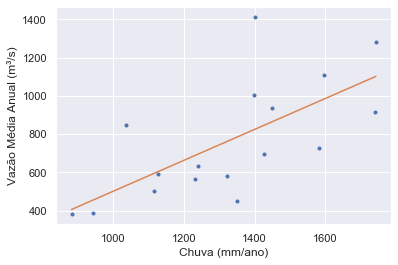

In [90]:
# Generate theoretical x and y data: x_theor, y_theor
x_theor = np.array([chuva_vazao_ah['Chuva'].min(), chuva_vazao_ah['Chuva'].max()])
y_theor = x_theor * slope + intercept

# Plot the Anscombe data and theoretical line
_ = plt.plot(chuva_vazao_ah['Chuva'], chuva_vazao_ah['Natural'], marker='.', linestyle='none')
_ = plt.plot(x_theor, y_theor, marker=' ', linestyle='-')

# Label the axes
plt.xlabel('Chuva (mm/ano)')
plt.ylabel('Vazão Média Anual (m³/s)')

# Show the plot
plt.show()

#### Regressões Multiplas

In [91]:
vazao_obs_ah = vazoes_maximas['Observada'].to_frame()
inicio = pd.to_datetime(['01/01/1975'])
fim = pd.to_datetime(['31/03/1993'])
vazao_obs_ah=vazao_obs_ah.loc[inicio[0]:fim[0]]
vazao_obs_ah.index=vazao_obs_ah.index.year
chuva_vazao_ah = pd.concat([chuva_vazao_ah,vazao_obs_ah],axis=1)
chuva_vazao_ah.head()

,Chuva,Natural,Observada
1975,881.5,379.52,1079.5
1976,1238.4,630.26,2479.6
1977,1321.9,581.93,1028.5
1978,1595.5,1109.96,6547.0
1979,1448.3,937.24,3845.0


In [92]:
formula = "Natural ~ Chuva + Observada"
model = smf.ols(formula, data=chuva_vazao_ah)
results=model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                Natural   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     22.29
Date:                Mon, 15 Jul 2019   Prob (F-statistic):           4.45e-05
Time:                        10:21:22   Log-Likelihood:                -108.81
No. Observations:                  17   AIC:                             223.6
Df Residuals:                      14   BIC:                             226.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     40.6958    226.722      0.179      0.8

In [93]:
intercept = results.params['Intercept']
slope1 = results.params['Chuva']
slope2 = results.params['Observada']

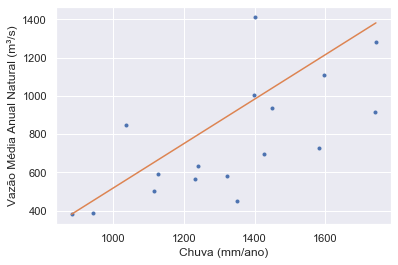

In [94]:
# Generate theoretical x and y data: x_theor, y_theor
x_theor = np.array([chuva_vazao_ah['Chuva'].min(), chuva_vazao_ah['Chuva'].max()])
z_theor = np.array([chuva_vazao_ah['Observada'].min(), chuva_vazao_ah['Observada'].max()])
y_theor = x_theor * slope1 + z_theor*slope2  + intercept

# Plot the Anscombe data and theoretical line
_ = plt.plot(chuva_vazao_ah['Chuva'], chuva_vazao_ah['Natural'], marker='.', linestyle='none')
_ = plt.plot(x_theor, y_theor, marker=' ', linestyle='-')

# Label the axes
plt.xlabel('Chuva (mm/ano)')
plt.ylabel('Vazão Média Anual Natural (m³/s)')

# Show the plot
plt.show()

#### Exploração de Dados

#### Regressão logística

#### Estimação de parâmetros

### Capítulo 12 - Análise de Séries Temporais

#### Médias Moveis

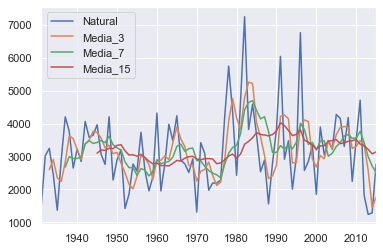

In [95]:
mov_natural = pd.DataFrame()
mov_natural['Natural'] = maximas_natural
mov_natural['Media_3']=mov_natural['Natural'].rolling(window = 3).mean()
mov_natural['Media_7']=mov_natural['Natural'].rolling(window = 7).mean()
mov_natural['Media_15']=mov_natural['Natural'].rolling(window = 15).mean()
mov_natural['Natural'].plot(legend=True)
mov_natural['Media_3'].plot(legend=True)
mov_natural['Media_7'].plot(legend=True)
mov_natural['Media_15'].plot(legend=True)

#### Correlação serial

In [96]:
corr_serial_naturais = thinkstats2.SerialCorr(vazoes_sf['Natural'], lag=1)
corr_serial_observadas = thinkstats2.SerialCorr(vazoes_sf['Observada'].dropna(), lag=1)
print('Correlação serial da Série de Vazões Naturais: {} \nCorrelação serial da Série de Vazões Observadas: {}'
      .format(round(corr_serial_naturais,3),round(corr_serial_observadas,3)))

Correlação serial da Série de Vazões Naturais: 0.982 
Correlação serial da Série de Vazões Observadas: 0.973


#### Auto Correlação

In [97]:
aut_corr_jusante = smtsa.acf(vazoes_sf['Natural'], nlags=365, unbiased=True)
day = np.arange(0,366,1)

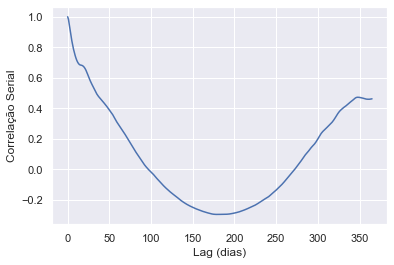

In [98]:
_=plt.plot(day,aut_corr_jusante)
# Label the axes
plt.xlabel('Lag (dias)')
plt.ylabel('Correlação Serial')

# Show the plot
plt.show()

#### Predição

### Capítulo 13 - Análise local de extremos

#### Distribuições Assintóticas de Valores Extremos

#### Distribuição GEV

##### Máximas

In [99]:
parameters = gev.fit(maximas_natural,loc=maximas_natural.mean(),scale=maximas_natural.std())
print('Parâmetros encontrados: c={}, loc={}, scale={}'
      .format(round(parameters[0],2),round(parameters[1],2),round(parameters[2],2)))

Parâmetros encontrados: c=0.06, loc=2666.92, scale=948.09


In [100]:
lmom_parameter=distr.gev.lmom_fit(maximas_natural)
print('Parâmetros encontrados: c={}, loc={}, scale={}'
      .format(round(lmom_parameter['c'],2),round(lmom_parameter['loc'],2),round(lmom_parameter['scale'],2)))

Parâmetros encontrados: c=0.08, loc=2676.84, scale=959.07


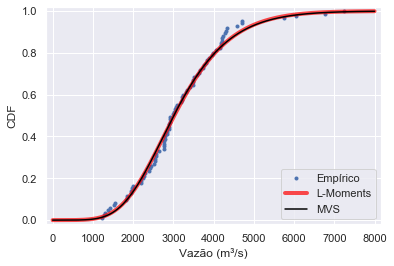

In [101]:
x_1, y_1 = ecdf(maximas_natural)
x_2 = np.linspace(0,8000,500)
y_2 = gev.cdf(x_2, lmom_parameter['c'], lmom_parameter['loc'], lmom_parameter['scale'])
y_3 = gev.cdf(x_2, parameters[0], parameters[1], parameters[2])
# Generate plot
_ = plt.plot(x_1, y_1, marker='.', linestyle = 'none')
_ = plt.plot(x_2, y_2, marker=' ', linestyle = '-',linewidth=4,color='red',alpha=0.7)
_ = plt.plot(x_2, y_3, marker=' ', linestyle = '-',linewidth=1.5,color='black')
# Label the axes
plt.legend(('Empírico', 'L-Moments','MVS'), loc='lower right')
_ = plt.xlabel('Vazão (m³/s)')
_ = plt.ylabel('CDF')

# Display the plot
plt.margins(0.02)
plt.show()

In [102]:
def creat_trs(fit,lmom):
    def creat_tr(parameters,nome):
        c,loc,scale=parameters
        tr2=gev.ppf(0.5, c, loc, scale)
        tr5=gev.ppf(0.8, c, loc, scale)
        tr10=gev.ppf(0.9, c, loc, scale)
        tr20=gev.ppf(0.95, c, loc, scale)
        tr25=gev.ppf(0.96, c, loc, scale)
        tr50=gev.ppf(0.98, c, loc, scale)
        tr100=gev.ppf(0.99, c, loc, scale)
        nome_coluna='Magnitude'+nome+' (m³/s)'
        trs = {'Tempo de Retorno (anos)': [2,5,10,20,25,50,100], nome_coluna: [tr2,tr5,tr10,tr20,tr25,tr50,tr100]}
        trs = pd.DataFrame(data=trs)
        trs=trs.set_index('Tempo de Retorno (anos)')
        return trs
    tr_fit=creat_tr(fit,'MVS')
    tr_lmom=creat_tr(lmom,'MML')
    trs=pd.concat([tr_fit,tr_lmom],axis=1)
    return trs
tr_fit=creat_trs(parameters,[lmom_parameter['c'],lmom_parameter['loc'],lmom_parameter['scale']])
tr_fit.round(2)

,MagnitudeMVS (m³/s),MagnitudeMML (m³/s)
Tempo de Retorno (anos),,
2,3010.92,3023.34
5,4031.71,4033.84
10,4673.26,4655.04
20,5264.16,5217.44
25,5446.75,5389.30
50,5994.98,5899.74
100,6518.50,6379.26


##### Mínimas

In [103]:
def ano_hidrologico_minimas(vazoes):
    media_mensal=vazoes['Natural'].groupby(vazoes['Natural'].index.month).mean()
    mes_menor_media=calendar.month_abbr[media_mensal.idxmin()+1].upper()
    frequencia='AS-'+mes_menor_media
    vazao_natural_ah=vazoes['Natural'].groupby(pd.Grouper(freq=frequencia)).min().sort_index()
    vazao_natural_ah=vazao_natural_ah[1:-1]
    return vazao_natural_ah

In [104]:
minimas_natural = ano_hidrologico_minimas(vazoes)

In [105]:
parameters = gev.fit(minimas_natural)
print('Parâmetros encontrados: c={}, loc={}, scale={}'
      .format(round(parameters[0],2),round(parameters[1],2),round(parameters[2],2)))

Parâmetros encontrados: c=0.24, loc=116.37, scale=48.42


In [106]:
lmom_parameter=distr.gev.lmom_fit(minimas_natural)
print('Parâmetros encontrados: c={}, loc={}, scale={}'
      .format(round(lmom_parameter['c'],2),round(lmom_parameter['loc'],2),round(lmom_parameter['scale'],2)))

Parâmetros encontrados: c=0.25, loc=116.64, scale=49.25


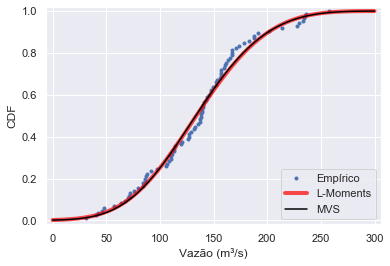

In [107]:
x_1, y_1 = ecdf(minimas_natural)
x_2 = np.linspace(0,300,300)
y_2 = gev.cdf(x_2, lmom_parameter['c'], lmom_parameter['loc'], lmom_parameter['scale'])
y_3 = gev.cdf(x_2, parameters[0], parameters[1], parameters[2])
# Generate plot
_ = plt.plot(x_1, y_1, marker='.', linestyle = 'none')
_ = plt.plot(x_2, y_2, marker=' ', linestyle = '-',linewidth=4,color='red',alpha=0.7)
_ = plt.plot(x_2, y_3, marker=' ', linestyle = '-',linewidth=1.5,color='black')
# Label the axes
plt.legend(('Empírico', 'L-Moments','MVS'), loc='lower right')
_ = plt.xlabel('Vazão (m³/s)')
_ = plt.ylabel('CDF')

# Display the plot
plt.margins(0.02)
plt.show()

### CAPÍTULO 14 - ANÁLISE DE SOBREVIVÊNCIA

•  O conceito fundamental na análise de sobrevivência é a curva de sobrevivência;
Sua função mapeia desde a duração, t, até à probabilidade de sobrevivência ser superior a t;
A curva de sobrevivência é o complemento da CDF (distribuição da duração); 
\begin{equation}
    S(t) = 1 - CDF(t)
\end{equation}
- $S(t)$ é Curva de sobrevivência
- $CDF(t)$ é a probabilidade de um tempo de vida inferior ou igual a t.

Parâmetros encontrados para a distribuição normal: loc=3160.84, scale=1137.27


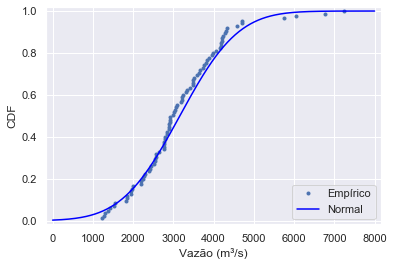

In [108]:
parameters = norm.fit(maximas_natural)
print('Parâmetros encontrados para a distribuição normal: loc={}, scale={}'
      .format(round(parameters[0],2),round(parameters[1],2)))
x_1, y_1 = ecdf(maximas_natural)
x_2 = np.linspace(0,8000,500)
y_2 = norm.cdf(x_2, parameters[0], parameters[1])
# Generate plot
_ = plt.plot(x_1, y_1, marker='.', linestyle = 'none')
_ = plt.plot(x_2, y_2, marker=' ', linestyle = '-',color='blue')

# Label the axes
plt.legend(('Empírico', 'Normal'), loc='lower right')
_ = plt.xlabel('Vazão (m³/s)')
_ = plt.ylabel('CDF')

# Display the plot
plt.margins(0.02)
plt.show()

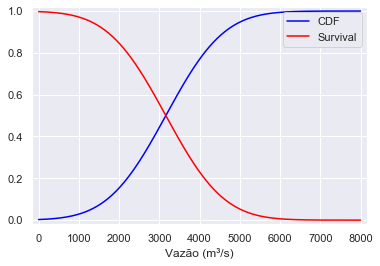

In [109]:
x_1 = np.linspace(0,8000,500)
y_1 = norm.cdf(x_1, parameters[0], parameters[1])
y_2 = norm.sf(x_1, parameters[0], parameters[1])
# Generate plot
_ = plt.plot(x_1, y_1, marker=' ', linestyle = '-',color='blue')
_ = plt.plot(x_1, y_2, marker=' ', linestyle = '-',color='red')
# Label the axes
plt.legend(('CDF', 'Survival'), loc='best')
_ = plt.xlabel('Vazão (m³/s)')

# Display the plot
plt.margins(0.02)
plt.show()

## Hazard Function

• A partir da curva de sobrevivência, podemos derivar a Hazard Function.

\begin{equation}
    \lambda(t) = \frac{S(t)-S(t+1)}{S(t)}
\end{equation}

\begin{equation}
    PMF(t) = S(t)-S(t+1)
\end{equation}

• Função de perigo modela quais períodos têm as maiores ou menores chances de um evento;

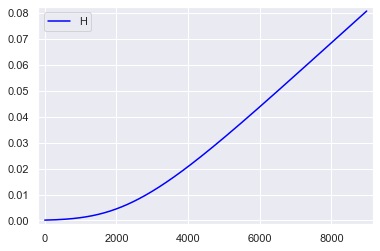

In [110]:
x_1 = np.linspace(0,9000,500)
y = norm.sf(x_1, parameters[0], parameters[1])
hf = (y[:-1]-y[1:])/y[:-1]

# Generate plot
_ = plt.plot(x_1[:-1], hf, marker=' ', linestyle = '-',color='blue')
# Label the axes
plt.legend(('Hazard'), loc='best')

# Display the plot
plt.margins(0.02)
plt.show()